In [1]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# chozhang@ethz.ch, 22-945-562
# minghli@student.ethz.ch, 22-953-293
# changli@student.ethz.ch, 22-944-474

In [2]:
# If you are in Kaggle, first go to notebook settings and add data from the stepcount competition
# The competition name is: Mobile Health 2023 - Step Count Submission
# After importing the dataset, run this code block to add Lilygo to the path
import os
import sys
curr_environ = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')
if curr_environ != 'Localhost': 
    sys.path.append('/kaggle/input/mobile-health-2023-step-count')
    input_dir = '/kaggle/input/mobile-health-2023-step-count'
else:
    input_dir = os.path.abspath('')

In [3]:
import pandas as pd
import numpy as np
from scipy import signal

from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
# %matplotlib inline

---

## Read data

In [4]:
# for tuning parameters
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

In [5]:
# Get the path of all traces
dir_traces = f'{input_dir}/data/traces'
dir_labeled_traces = f'{input_dir}/data/labeled_traces'
traces_fnames = [join(dir_traces, f)
                 for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
labeled_traces_fnames = [join(dir_labeled_traces, f)
                         for f in listdir(dir_labeled_traces) if isfile(join(dir_labeled_traces, f)) and not 'csv' in f]
traces_fnames.sort()
labeled_traces_fnames.sort()


In [6]:
traces = [Recording(f, no_labels=True, mute=True) for f in traces_fnames]
# not sure if I should change no_labels to False
labeled_traces = [Recording(f, no_labels=True, mute=True) for f in labeled_traces_fnames]

In [7]:
df = pd.read_csv(f'{input_dir}/data/labeled_traces/labels.csv')
expected_counts = df['Expected'].to_list()

### Self-recorded data

In [8]:
dir_pig_traces = '/kaggle/input/pigwalk'
pig_traces_fnames = [join(dir_pig_traces, f)
                     for f in listdir(dir_pig_traces) if isfile(join(dir_pig_traces, f))]
pig_traces_fnames.sort()
pig_traces_fnames

['/kaggle/input/pigwalk/matchy_lilygo_zchome_lotsofactivities_210.json',
 '/kaggle/input/pigwalk/zc_lilygo_zchome_130.json']

In [9]:
pig_traces = [Recording(f, no_labels=True, mute=True) for f in pig_traces_fnames]
pig_label = [int(f.split('_')[-1].split('.')[0]) for f in pig_traces_fnames]

---

## Coding

The code block below defines the stepcounter

In [10]:
### signal processing functions ###
def parse(signal, ds_freq:float=20.0, zero_mean:bool=False):
    """downsampling the signal to specific frequency ds_freq, and make the data
     with zero mean if zero_mean is True"""
    ori_time_seq = np.array(signal.timestamps)
    ori_value_seq = np.array(signal.values)
    if zero_mean: ori_value_seq = ori_value_seq - np.mean(ori_value_seq)
    dt = 1./ds_freq
    time_seq = np.arange(start=np.min(ori_time_seq), stop=np.max(ori_time_seq), step=dt)
    value_seq = np.interp(time_seq, ori_time_seq, ori_value_seq)
    return time_seq, value_seq
    
def bp_filter(value_seq, fp:float=3, fs:float=20.0):
    """apply band pass filter to the sequence. fp is the threshold frequency,
     and fs is the sampling frequency."""
    sos = signal.butter(N=4, Wn=[0.5,fp], btype='bandpass', fs=fs, output='sos')
    filtered = signal.sosfilt(sos, value_seq)
    return filtered
    
def get_envelop(value_seq, 
                fs:float=20, 
                half_window_size:float=0.5, 
                _min:float=20., 
                _max:float=500.):
    """
    get the envelop as the adaptive local norm of the signal, currently the mode
     of vector (no negative values). The envelop is calculated by the maximum in
     a window, half_window_size is the seconds of time. _min and _max for clip.
    """
    half_win = int(fs*half_window_size)
    seq = np.concatenate([np.zeros((half_win,)),value_seq,np.zeros((half_win,))])
    envelop = np.array([np.max(seq[k-half_win:k+half_win+1]) 
                        for k in range(half_win,half_win+len(value_seq))])
    return np.clip(envelop, _min, _max)

In [11]:
class StepCounter(BaseEstimator):
    def __init__(self, acc_min=2.,  acc_max=3.,    acc_height=0.25,
                 gyro_min=20., gyro_max=500., gyro_height=0.5,
                 acc_weight=1.0, half_window_size=0.5, width=0.5):
        self.acc_min = acc_min
        self.acc_max = acc_max
        self.acc_height = acc_height
        self.gyro_min = gyro_min
        self.gyro_max = gyro_max
        self.gyro_height = gyro_height
        self.acc_weight = acc_weight
        self.half_window_size = half_window_size
        self.width = width

    def fit(self, data, labels):
        # no learning actually, just to fit the estimator interface
        return self

    def score(self, X, y_true, sample_weight=None, normalize=True) -> float:
        '''
        Get the "score" of the step counting result. 
        The score is calculated based on how different the step count is from the true values
        '''
        y_predicted = self.predict(X)
        diff = y_predicted - y_true
        scores = np.zeros(len(diff))
        for i in range(len(diff)):
            s = - abs(diff[i])
            scores[i] = s
        if normalize:
            return np.average(scores, weights=sample_weight)
        elif sample_weight is not None:
            return np.dot(scores, sample_weight)
        else:
            return scores.sum()

    def predict(self, traces):
        # assume array
        if hasattr(traces, '__len__'):
            res = np.zeros(len(traces))
            _traces = traces
        else:
            res = np.zeros(1)
            _traces = [traces]
        i = 0
        for trace in _traces:
            data = trace.data
            # accelerator data
            ax, ay, az = data['ax'], data['ay'], data['az']
            # gyroscope data
            gx, gy, gz = data['gx'], data['gy'], data['gz']
            acc_step_counts = self._count_steps(ax, ay, az,
                                                _max=self.acc_max,
                                                _min=self.acc_min,
                                                _height=self.acc_height,
                                                half_window_size=self.half_window_size,
                                                width=self.width)
            gyro_step_counts = 0
            if self.acc_weight != 1.0:
                gyro_step_counts = self._count_steps(gx, gy, gz,
                                                    _max=self.gyro_max,
                                                    _min=self.gyro_min,
                                                    _height=self.gyro_height,
                                                    half_window_size=self.half_window_size,
                                                    width=self.width)
            res[i] = int(self.acc_weight * acc_step_counts +
                         (1.0 - self.acc_weight) * gyro_step_counts)
            i += 1
        if len(res) == 1:
            return res[0]
        else:
            return res

    def _count_steps(self, ax, ay, az, _max, _min, _height,
                     half_window_size=0.5, width=0.5):
        # interval of m and temp: 80ms; others 50ms
        # acc are in unit "g". gyro should be within -255, 255
        g_t, gx_v = parse(ax)  # use acceleration seems better.
        _, gy_v = parse(ay)
        _, gz_v = parse(az)

        # calculate the mode.
        g_v = np.sqrt(np.sum(np.square([gx_v, gy_v, gz_v]), axis=0))
        g_v /= get_envelop(g_v,
                           half_window_size=half_window_size,
                           _min=_min,
                           _max=_max)  # an adaptive local norm
        # band pass
        filtered_gv = bp_filter(g_v)
        # amp 1/4 after filtering, should be amplified 4x.
        filtered_gv = filtered_gv * (filtered_gv > 0) * 4

        # 0.5 optimal for gyro. not tuned for acc but I am lazy.
        peaks, _ = signal.find_peaks(filtered_gv,
                                     height=_height,
                                     distance=20 * 0.2)
        # when _min=20 for acc, height=0.01 looks good. sota: _min=1, height=0.25
        step_count = len(peaks)  # peaks are the steps.
        return step_count


---

## Data Exploration

The code block below plot data shape

228
108


<Figure size 1500x2000 with 0 Axes>

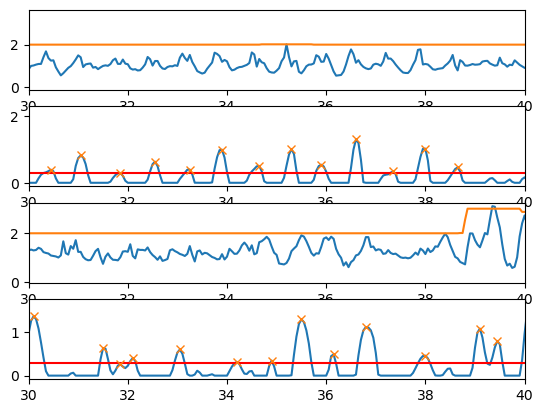

In [12]:
plt.figure(figsize=(15.0,20.0))
plt.subplots(20,1, sharex=True)

# pick traces to lookat
picked_traces = pig_traces
file_id = 0
for trace in picked_traces:
    stepCount = 0  # This is your variable of the step counting that you need to change
    data = trace.data
    ax, ay, az, = data['ax'], data['ay'],data['az']
    plot_window = [30, 40]
    
    g_t, gx_v = parse(ax)
    _, gy_v = parse(ay)
    _, gz_v = parse(az)
    g_v = np.sqrt(np.sum(np.square([gx_v,gy_v,gz_v]),axis=0))  # calculate the mode.
    
    plt.subplot(2 * len(picked_traces),1,file_id*2+1)
    plt.plot(g_t,g_v)
    plt.plot(g_t,get_envelop(g_v, _min=2.0, _max=3.0))
    plt.xlim(plot_window)
#     print(np.min(g_v),np.max(g_v))

    g_v /= get_envelop(g_v, _min=2.0, _max=3.0)  # an adaptive local norm
    filtered_gv = bp_filter(g_v)  # band pass it.
    filtered_gv = filtered_gv * (filtered_gv>0) * 4  # amp 1/4 after filtering, should be amplified 4x.
    plt.subplot(2 * len(picked_traces),1,file_id*2+2)
    plt.plot(g_t,filtered_gv)
    plt.hlines(0.3, 0,np.max(g_t),color='r')
    plt.xlim(plot_window)
    file_id += 1

    peaks, _ = signal.find_peaks(filtered_gv, height=0.25, distance=20*0.2)
    plt.plot(peaks*0.05, filtered_gv[peaks], "x")
    
    stepCount = len(peaks)  # peaks are the steps.
    print(stepCount)


---
## Parameter tuning

In [13]:
# This code block is for parameter tuning and will take decades to finish
# do not run unless you want to tune param
step_counter = StepCounter()
parameters = {
    "half_window_size": np.arange(0.1, 1.1, step=0.05),
}
param_tuner = GridSearchCV(step_counter, parameters, cv=len(labeled_traces))
param_tuner.fit(labeled_traces, expected_counts)

print(param_tuner.best_score_)
print(param_tuner.best_params_)

-3.3
{'half_window_size': 0.8500000000000002}


---
## Prediction

In [14]:
pig_counters = StepCounter(half_window_size=0.8)
predict_pigs = pig_counters.predict(pig_traces)
predict_pigs

array([227., 109.])

In [15]:
pig_label

[210, 130]


---

## Results

Below is the template

In [16]:
# Get the path of all traces
dir_traces = '/kaggle/input/mobile-health-2023-step-count/data/traces'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
filenames.sort()

In [17]:
# Loop through all traces and calculate the step count for each trace
stepCounts = []
ids = []
best_step_counter = StepCounter(half_window_size=0.8)
for filename in filenames:
    trace = Recording(filename, no_labels=True, mute=True)
    stepCount = 0  # This is your variable of the step counting that you need to change

    #
    # Your algorithm goes here
    # Make sure, you only use data from the LilyGo Wristband, namely the following 10 keys (as in trace.data[key]):
    # 3-axis accelerometer: key in [ax, ay, az]
    # 3-axis gyro: key in [gx, gy, gz]
    # 3-axis magnetometer: key in [mx, my, mz]
    # IMU temperature: key==temperature
    #
    stepCount = best_step_counter.predict(trace)

    # Append your calculated step counts and the id of the trace to the corresponding array
    stepCounts.append(stepCount)
    ids.append(filename.split('_')[1][:2])
print(stepCounts)

[101.0, 195.0, 94.0, 92.0, 107.0, 109.0, 118.0, 36.0, 148.0, 53.0]


In [18]:
# Write the detected step counts into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using the text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns ('Id' and 'Predicted') of the .csv file
df = pd.DataFrame({'Id':ids,'Predicted':stepCounts})
df.to_csv('/kaggle/working/submission.csv', index=False)